In [12]:
%matplotlib inline
import numpy as np
from IPython.display import display, Markdown
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
plt.style.use('seaborn-darkgrid')

In [13]:
def TimeSeriesLoader(url):

  """
  Este Loader se puede cambiar según la fuente, en ese caso, tambien habría que cambiar un poco la función
  GetObs_and_times(estado,Pop)
  """
  df = pd.read_csv(url)

  df['Reporte'] = pd.to_datetime(df['Reporte'])
  df = (df.drop(["Procedencia", "Llegada","Inicio","Caso","Sexo","Edad","Confirmación"], axis=1)
          .dropna()
          .rename(columns = {"Reporte":"Dia"})
          .sort_values(by = ["Dia"])
          .reset_index(drop = True)
        )
  df["Casos_Acumulados"] = np.nan
  Estados = pd.DataFrame({
    "Estado":[],
    "Dia":[],
    "Casos_Acumulados":[]
  })

  for estado in df.Estado.unique():
      df.loc[(df.Estado == estado),"Casos_Acumulados"] =  np.arange(1,len(df.loc[(df.Estado == estado),"Casos_Acumulados"])+1,1)
      tmp = df.loc[df.Estado == estado].drop_duplicates("Dia", keep = 'last').reset_index(drop = True)
      Estados = pd.concat([Estados,tmp])
  return Estados

In [34]:
def GetObs_and_times(estado,Pop):
  from scipy.interpolate import InterpolatedUnivariateSpline
  """
  Esta funcion genera las condiciones inciales para PyMC3 a partir de las observaciones de 
  Infectados en un estado y dada la población del estado (se debe ingresar el número)
  como los registros de recuperados en mexico son nulos se asumen 0.
  """
  yobs = Estados.loc[Estados.Estado == estado,"Casos_Acumulados"].values
  date = Estados.loc[Estados.Estado == estado,"Dia"].values
  days = Estados.loc[Estados.Estado == estado,"Dia"].dt.day.values

  date_df = Estados.loc[Estados.Estado == estado,"Dia"]
  days_i = date_df.apply(lambda x: (x - date_df[0]).days).values
  times = np.arange(0,max(days_i) + 1,1)
    
  #print(days_i) 
  #print(times) 
    
  interp = InterpolatedUnivariateSpline(days_i,yobs,k=2)
  obs_interp = interp(times)

  def SI_Day(obs):
    I = obs / Pop
    S = 1 - (I)
    return [S, I]

  yobs_arr = np.array([SI_Day(obs) for obs in obs_interp])
  times_interp = np.arange(days[0],days[-1]+1,1)

  ## Crear un arreglo de N x 3 para enviar como estados al sistema
  return obs_interp, times, date

In [35]:
Estados = TimeSeriesLoader("https://gist.githubusercontent.com/said3427/18f39eab460766a17ea4802607dd5522/raw")

In [36]:
Estados.head()

Estado        Dia  Casos_Acumulados
0  Ciudad De México 2020-02-27               1.0
1  Ciudad De México 2020-02-29               2.0
2  Ciudad De México 2020-03-07               3.0
3  Ciudad De México 2020-03-11               5.0
4  Ciudad De México 2020-03-13              11.0

In [37]:
Estados.Estado.unique()

array(['Ciudad De México', 'Sinaloa', 'Coahuila', 'Chiapas', 'México',
       'Nuevo León', 'Queretaro', 'Durango', 'Quintana Roo', 'Yucatán',
       'Puebla', 'Oaxaca', 'Jalisco', 'San Luis Potosí', 'Guerrero',
       'Aguascalientes', 'Guanajuato', 'Sonora', 'Tamaulipas',
       'Chihuahua', 'Tabasco', 'Veracruz', 'Colima', 'Baja California',
       'Hidalgo', 'Morelos', 'Baja California Sur', 'Zacatecas',
       'Nayarit', 'Campeche', 'Michoacán', 'Tlaxcala'], dtype=object)

In [38]:
N = 8000000

In [39]:
obs_interp,times_interp,date = GetObs_and_times('Jalisco',N)

[ 0  3  4  5  6  7  8  9 12 13 14 15 16 17]
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17]


In [42]:
print(f"Infectados:{obs_interp}")
print(f"dias:{times_interp}")
Estados.loc[Estados.Estado == "Jalisco","Casos_Acumulados"].values

Infectados:[ 2.          4.53919963  5.53919963  5.          6.         22.
 28.         32.         41.         46.         48.72224814 50.85289113
 59.         72.         77.         78.         85.         89.        ]
dias:[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17]


array([ 2.,  5.,  6., 22., 28., 32., 41., 46., 59., 72., 77., 78., 85.,
       89.])

In [43]:
def sir_model(y, x, beta, gamma):
    S = -beta * y[0] * y[1] / N
    R = gamma * y[1]
    I = -(S + R)
    return S, I, R

In [44]:
ydata = np.array(obs_interp, dtype=float)
xdata = np.array(times_interp, dtype=float)

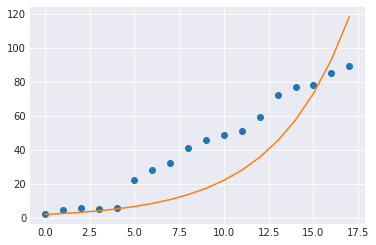

In [45]:
from scipy import integrate, optimize

I0 = ydata[0]
S0 = N - I0
R0 = 0.0

def fit_odeint(x, beta, gamma):
    return integrate.odeint(sir_model, (S0, I0, R0), x, args=(beta, gamma))[:,1]

# trust-region reflective algorithm                                             
# los bounds reflejan una Ro que va de 1.5 a 6 y una gamma que va de .1 a .5
popt, pcov = optimize.curve_fit(fit_odeint, xdata, ydata,p0=[1.75,0.5], bounds=([.15,.1],[3, .5]))
fitted = fit_odeint(xdata, *popt)
base = fit_odeint(xdata, 1.75,0.5)
plt.plot(xdata, ydata, 'o')
plt.plot(xdata, fitted)
plt.show()

# https://www.sciencedirect.com/science/article/pii/S2468042717300234#sec5

In [46]:
popt

array([0.73992882, 0.49999992])

In [47]:
Ro = popt[0]/popt[1]
Ro

1.4798578806826144

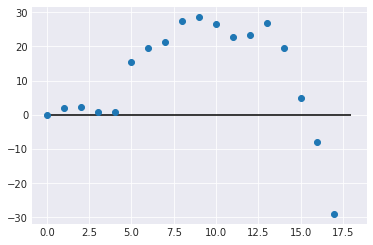

In [48]:
resid = (ydata-fitted)
plt.plot(xdata,resid,"o")
plt.hlines(0,0,len(xdata),"k")

Aplicando estimación poisson

In [49]:
from scipy.stats import poisson
lb, hb = poisson.interval(0.95, fitted)

In [50]:
#calcular R0 para boundaries

lb_popt, pcov = optimize.curve_fit(fit_odeint, xdata, lb ,p0=[1.75,0.5], bounds=([.15,.1],[3, .5]))
lb_fitted = fit_odeint(xdata, *popt)

In [51]:
lb_popt

array([0.72463533, 0.5       ])

In [52]:
Ro_l = lb_popt[0]/lb_popt[1]

In [53]:
hb_popt, pcov = optimize.curve_fit(fit_odeint, xdata, hb ,p0=[1.75,0.5], bounds=([.15,.1],[3, .5]))
hb_fitted = fit_odeint(xdata, *popt)

In [54]:
hb_popt

array([0.75268114, 0.49999994])

In [55]:
Ro_h = hb_popt[0]/hb_popt[1]

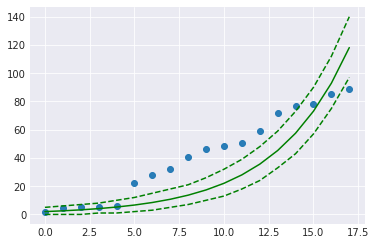

In [56]:
plt.plot(xdata, ydata, 'o', alpha=0.95)
plt.plot(xdata, fitted, color = "green")
plt.plot(xdata, lb, "--", color = "green")
plt.plot(xdata, hb, "--",color = "green")
plt.show()

In [57]:
Betas = np.arange(lb_popt[0],hb_popt[0]+0.001,0.004)
Betas

array([0.72463533, 0.72863533, 0.73263533, 0.73663533, 0.74063533,
       0.74463533, 0.74863533, 0.75263533])

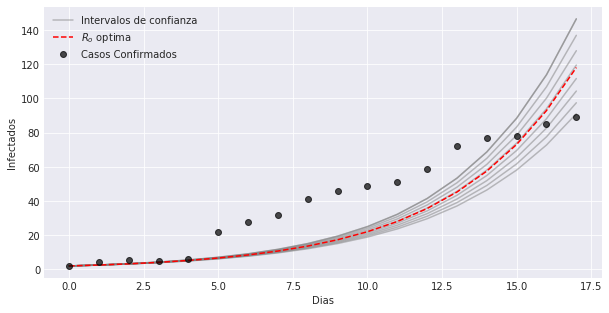

In [58]:
plt.figure(figsize=(10,5)) 
for beta in Betas:
    plt.plot(fit_odeint(xdata, beta, 0.5),alpha=0.5,color="gray")
plt.plot(fit_odeint(xdata, Betas[-1], 0.5),alpha=0.5,color="gray", label= "Intervalos de confianza")
plt.plot(xdata, fitted, color = "red", linestyle = "--", label= f"$R_o$ optima")
plt.plot(xdata,ydata,"o",alpha=0.7,color = "k", label ="Casos Confirmados")
plt.ylabel("Infectados")
plt.xlabel("Dias")
plt.legend()


In [59]:
dias_evaluacion = 120
dt=.01
periodo_evaluacion = np.arange(0,dias_evaluacion+dt,dt)

#Escenarios
def Base():
    Ro = 1.54 
    gamma = 0.5
    Beta = Ro*gamma
    return Beta
 
def Pesimista():
    Ro = 5
    gamma = 0.5
    Beta = Ro*gamma
    return Beta
 
def Optimista():
    Ro = 1.3
    gamma = 0.5
    Beta = Ro*gamma
    return Beta

def Fuerte():
    Ro = 1.54*(0.5)
    gamma = 0.5
    Beta = Ro*gamma
    return Beta

def Moderada():
    Ro = 1.54 - (1.54*(0.25))
    gamma = 0.5
    Beta = Ro*gamma
    return Beta
 
switcher = {
   "Base": Base,
   "Pesimista": Pesimista,
   "Optimista": Optimista,
   "Fuerte": Fuerte,
   "Moderada": Moderada
    }
 
def get_Beta(argument):
# Get the function from switcher dictionary
  func = switcher.get(argument, "nothing")
# Execute the function
  return func()

alpha = 0.2
gamma = 0.5
rho = 0.82
kappa = .016
parametros = alpha, gamma, rho , kappa
Population = N

I_o = obs_interp[-1] / Population  
E_o = (obs_interp[-1]*4)/ Population 
A_o =  0 / Population
D_o = 0 # No Muertos
S_o = (1) - (E_o+I_o+A_o+D_o) # El resto somos suceptibles
R_o = 0 # NO hay ningun recuperado


Condiciones_Iniciales = S_o,E_o,A_o,I_o,R_o,D_o



def SEAIR_D(IC, pmtrs, t, intervencion = "Base", inicio_intervencion=1, duracion_intervencion=119):
  """
  Esta parte de código es la que implementa las ecuaciones diferenciales.

  Se resuelven por medio de integración númerica de Euler
  """
  
  So,Eo,Ao,Io,Ro,Do = IC
  S,E,A,I,R,D = [So],[Eo],[Eo],[Io],[Ro],[Do]
  alpha,gamma,rho,kappa = pmtrs
  dt = t[1]-t[0]
  for i in t[1:]:
    if (i >= inicio_intervencion and i <=(duracion_intervencion+inicio_intervencion)):
      beta = get_Beta(intervencion)
    else:
      beta = get_Beta("Base")


    St = S[-1] - (beta*S[-1]*I[-1])*dt
    Et = E[-1] + (beta*S[-1]*I[-1] - alpha*E[-1])*dt
    At = A[-1] + (1-rho)*(alpha*E[-1] - gamma*A[-1])*dt
    It = I[-1] + rho*(alpha*E[-1] - gamma*I[-1])*dt
    Dt = kappa*I[-1]
    Rt = 1 - (S[-1]+E[-1]+A[-1]+I[-1]-D[-1])
    
    S.append(St)
    E.append(Et)
    A.append(At)
    I.append(It)
    R.append(Rt)
    D.append(Dt)
  return S,E,A,I,R,D, intervencion

In [60]:
import plotly.express as px
S,E,A,I,R,D, intervencion = SEAIR_D(Condiciones_Iniciales,parametros,periodo_evaluacion,"Base",1,119)
E_a = np.array(E)*Population
I_a = np.array(I)*Population
A_a = np.array(A)*Population
D_a = np.array(D)*Population
Clase = np.array(["Expuestos"]*np.array(E).shape[0] + ["Infectados"]*np.array(E).shape[0]+ 
                  ["Asintomaticos o No reportados"]*np.array(E).shape[0] + ["Muertes"]*np.array(E).shape[0])
Dias = np.concatenate([periodo_evaluacion,periodo_evaluacion,periodo_evaluacion,periodo_evaluacion])
SEIR_df = pd.DataFrame({
    "Casos": np.concatenate([E_a,I_a,A_a,D_a]),
    "Clase": Clase,
    "Dias" : Dias
})

fig = px.line(SEIR_df, x="Dias", y="Casos", color='Clase',color_discrete_sequence=["green", "red", "goldenrod", "blue"], template = "ggplot2")

fig.update_layout(
    title=f"Predicción del modelo SEAIR de la evolución de COVID-19, Escenario: {intervencion}",
    
    xaxis_title="Días",
    yaxis_title="Casos Totales",
    )

fig.show()

Bayesian negative binomial (Otra forma que se me ocurrió)

In [61]:
selected_states = ["Nuevo León","Jalisco"]

In [62]:
import arviz as az
import pymc3 as pm
n_states = len(selected_states)
with pm.Model() as model:
    ############
    # Intercept
    # Group mean
    a_grp = pm.Normal('a_grp', 100, 50)
    # Group variance
    a_grp_sigma = pm.HalfNormal('a_grp_sigma', 50)
    # Individual intercepts
    a_ind = pm.Normal('a_ind', 
                      mu=a_grp, sigma=a_grp_sigma, 
                      shape=n_states)
    ########
    # Slope
    # Group mean
    b_grp = pm.Normal('b_grp', 1.33, .5)
    # Group variance
    b_grp_sigma = pm.HalfNormal('b_grp_sigma', .5)
    # Individual slopes
    b_ind = pm.Normal('b_ind', 
                      mu=b_grp, sigma=b_grp_sigma, 
                      shape=n_states)
    
    # Error
    sigma = pm.HalfNormal('sigma', 500., shape=n_states)
    
    # Create likelihood for each country
    for i, state in enumerate(selected_states):
        df_state = Estados.loc[lambda x: (x.Estado == state)]
        
        # By using pm.Data we can change these values after sampling.
        # This allows us to extend x into the future so we can get
        # forecasts by sampling from the posterior predictive
        x = pm.Data(state + "x_data", 
                    xdata.astype('float64'))
        cases = pm.Data(state + "y_data", 
                        ydata.astype('float64'))
        
        # Likelihood
        pm.NegativeBinomial(
            state, 
            (a_ind[i] * b_ind[i] ** x), # NB regression
            sigma[i], 
            observed=cases)

In [63]:
with model:
    # Sample posterior
    trace = pm.sample(tune=2000, chains=2, cores=2, target_accept=.95)
    
    # Update data so that we get predictions into the future
    for state in selected_states:
        df_state = Estados.loc[lambda x: (x.Estado == state)]
        x_data = np.arange(xdata[-1],xdata[-1]+10,1) #10 dias de forecast
        y_data = np.array([np.nan] * len(x_data))
        pm.set_data({state + "x_data": x_data})
        pm.set_data({state + "y_data": y_data})
    
    # Sample posterior predictive
    post_pred = pm.sample_posterior_predictive(trace, samples=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, b_ind, b_grp_sigma, b_grp, a_ind, a_grp_sigma, a_grp]
Sampling 2 chains, 22 divergences: 100%|██████████| 5000/5000 [01:45<00:00, 47.26draws/s]
There were 15 divergences after tuning. Increase `target_accept` or reparameterize.
There were 7 divergences after tuning. Increase `target_accept` or reparameterize.
The estimated number of effective samples is smaller than 200 for some parameters.
100%|██████████| 1000/1000 [00:20<00:00, 48.31it/s]


Text(0.5, 1.0, 'Estimates of Daily Growth of COVID-19')

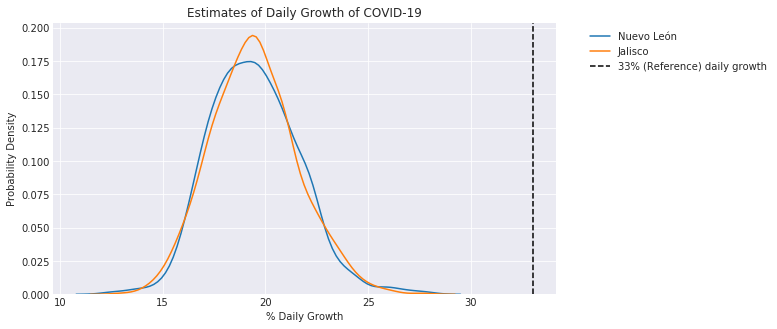

In [89]:
plt.figure(figsize=(9,5))
for i, state in enumerate(selected_states):
    sns.distplot((trace['b_ind'][:, i] * 100) - 100, label=state, hist=False)
plt.axvline(33, ls='--', color='k', label='33% (Reference) daily growth')
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.xlabel("% Daily Growth")
plt.ylabel("Probability Density")
plt.title("Estimates of Daily Growth of COVID-19")

In [90]:
 post_pred["Jalisco"].shape

(1000, 10)

Text(0.5, 0, 'Dias')

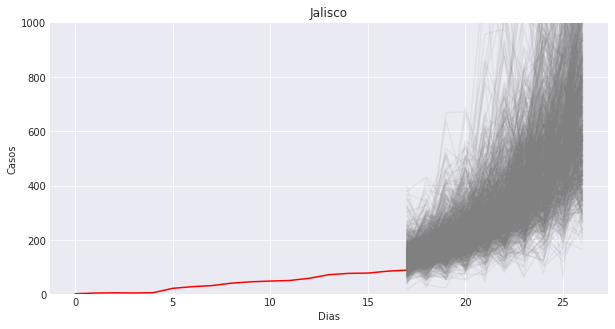

In [91]:
plt.figure(figsize=(10,5)) 
plt.plot(xdata,ydata,color='r')
plt.plot(np.arange(xdata[-1],xdata[-1]+post_pred["Jalisco"].shape[1]),  post_pred["Jalisco"].T, alpha=.10, color='gray')

plt.title("Jalisco")
plt.ylim(0,1000)
plt.ylabel("Casos")
plt.xlabel("Dias")

In [92]:
ppc_samples = post_pred["Jalisco"]
mean_ppc = ppc_samples.mean(axis=0)
CriL_ppc = np.percentile(ppc_samples,q=2.5,axis=0)
CriU_ppc = np.percentile(ppc_samples,q=97.5,axis=0)

Text(0.5, 0, 'Dias')

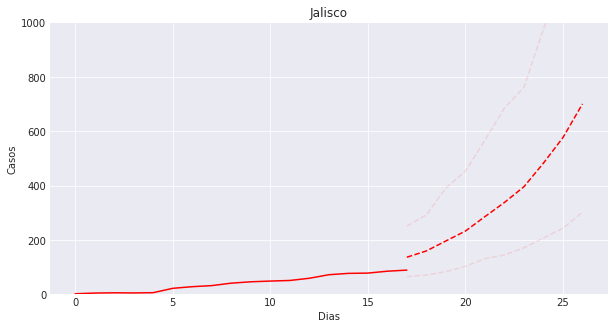

In [93]:
plt.figure(figsize=(10,5)) 
plt.plot(xdata,ydata,color='r')
plt.plot(np.arange(xdata[-1],xdata[-1]+post_pred[state].shape[1]),mean_ppc, color='r', linestyle = "--", label = "Mean PPC")
plt.plot(np.arange(xdata[-1],xdata[-1]+post_pred[state].shape[1]),CriL_ppc, alpha=.10, color='r', linestyle = "--")
plt.plot(np.arange(xdata[-1],xdata[-1]+post_pred[state].shape[1]),CriU_ppc, alpha=.10, color='r', linestyle = "--", label = "95% Credible Intervals")
plt.title("Jalisco")

plt.ylim(0,1000)
plt.ylabel("Casos")
plt.xlabel("Dias")

concatenations to produce Ros boundaries

In [94]:
mean =  mean_ppc[np.where(mean_ppc>ydata[-1])[0][0]:]
mean_scenario = np.concatenate((ydata,mean))
print(mean_scenario)


[  2.           4.53919963   5.53919963   5.           6.
  22.          28.          32.          41.          46.
  48.72224814  50.85289113  59.          72.          77.
  78.          85.          89.         136.435      159.548
 196.201      232.614      285.731      337.838      395.797
 482.564      576.689      700.344     ]


In [95]:
lw = CriL_ppc[np.where(CriL_ppc>ydata[-1])[0][0]:]

In [96]:
lower_scenario = np.concatenate((ydata,lw))

In [97]:
lower_scenario

array([  2.        ,   4.53919963,   5.53919963,   5.        ,
         6.        ,  22.        ,  28.        ,  32.        ,
        41.        ,  46.        ,  48.72224814,  50.85289113,
        59.        ,  72.        ,  77.        ,  78.        ,
        85.        ,  89.        , 102.975     , 130.975     ,
       144.975     , 170.95      , 207.        , 243.        ,
       302.        ])

In [98]:
up = CriU_ppc[np.where(CriU_ppc>ydata[-1])[0][0]:]

In [99]:
higher_scenario = np.concatenate((ydata,up))

In [100]:
higher_scenario

array([   2.        ,    4.53919963,    5.53919963,    5.        ,
          6.        ,   22.        ,   28.        ,   32.        ,
         41.        ,   46.        ,   48.72224814,   50.85289113,
         59.        ,   72.        ,   77.        ,   78.        ,
         85.        ,   89.        ,  251.        ,  292.        ,
        391.1       ,  453.075     ,  567.15      ,  685.3       ,
        761.175     ,  976.2       , 1157.125     , 1481.        ])

In [101]:
xl = np.arange(0,len(lower_scenario),1)
xm = np.arange(0,len(mean_scenario),1)
xh = np.arange(0,len(higher_scenario),1)
print(xl)
print(xm)
print(xh)

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24]
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27]
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27]


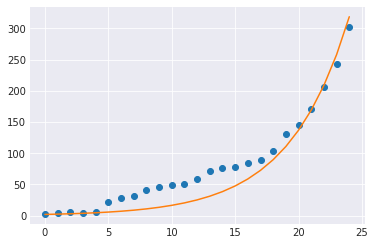

In [102]:
popt, pcov = optimize.curve_fit(fit_odeint,xl,lower_scenario,p0=[1.75,0.5], bounds=([.15,.1],[3, .5]))
fitted = fit_odeint(xl, *popt)
plt.plot(xl, lower_scenario, 'o')
plt.plot(xl, fitted)
plt.show()


In [103]:
Ro_lower =  popt[0] / popt[1]
Ro_lower

1.4226651226611637

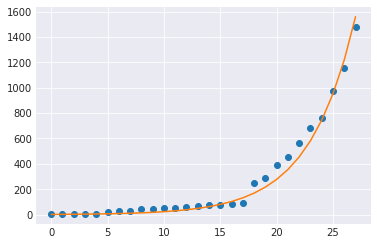

In [104]:
popt, pcov = optimize.curve_fit(fit_odeint,xh,higher_scenario,p0=[1.75,0.5], bounds=([.15,.1],[3, .5]))
fitted = fit_odeint(xh, *popt)
plt.plot(xh, higher_scenario, 'o')
plt.plot(xh, fitted)
plt.show()


In [105]:
Ro_higher =  popt[0] / popt[1]
Ro_higher

1.4933587678363707

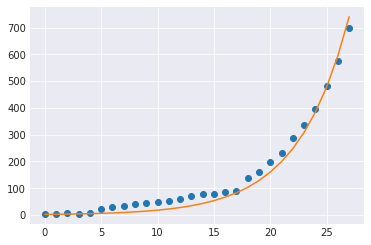

In [106]:
popt, pcov = optimize.curve_fit(fit_odeint,xm,mean_scenario,p0=[1.75,0.5], bounds=([.15,.1],[3, .5]))
fitted = fit_odeint(xm, *popt)
plt.plot(xm, mean_scenario, 'o')
plt.plot(xm, fitted)
plt.show()

In [107]:
Ro_mean =  popt[0] / popt[1]
Ro_mean

1.438173826753564

In [108]:
print(f"$R_0$ alta: {Ro_higher}")
print(f"$R_0$ media: {Ro_mean}")
print(f"$R_0$ baja: {Ro_lower}")

$R_0$ alta: 1.4933587678363707
$R_0$ media: 1.438173826753564
$R_0$ baja: 1.4226651226611637


In [109]:
Betas = np.arange(Ro_lower*0.5,Ro_higher*0.5+0.001,0.002)
Betas

array([0.71133256, 0.71333256, 0.71533256, 0.71733256, 0.71933256,
       0.72133256, 0.72333256, 0.72533256, 0.72733256, 0.72933256,
       0.73133256, 0.73333256, 0.73533256, 0.73733256, 0.73933256,
       0.74133256, 0.74333256, 0.74533256, 0.74733256])

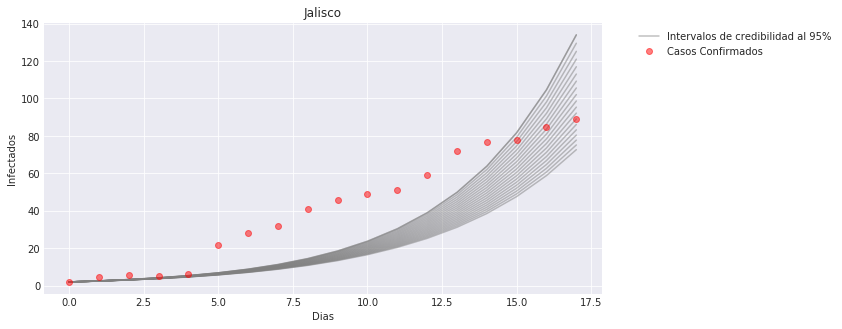

In [110]:
plt.figure(figsize=(10,5)) 
for beta in Betas:
    plt.plot(fit_odeint(xdata, beta, 0.5),alpha=0.5,color="gray")
plt.plot(fit_odeint(xdata, Betas[-1], 0.5),alpha=0.5,color="gray", label= "Intervalos de credibilidad al 95%")
plt.plot(xdata,ydata,"o",alpha=0.5,color = "r", label ="Casos Confirmados")
plt.title("Jalisco")
plt.ylabel("Infectados")
plt.xlabel("Dias")
plt.legend()
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')

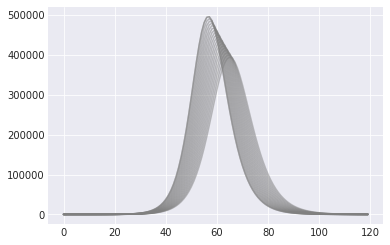

In [111]:
for beta in Betas:
    plt.plot(fit_odeint(np.arange(0,120,1), beta, 0.5),alpha=0.5,color="gray")
plt.plot(fit_odeint(np.arange(0,120,1), Betas[-1], 0.5),alpha=0.5,color="gray", label= "Intervalos de credibilidad al 95%")

Plugin a SEAIR modificado (le puse como parametro beta, para poder hacer el barrido)

In [112]:
alpha = 0.2
gamma = 0.5
rho = 0.82
kappa = .016
parametros = alpha, gamma, rho , kappa
Population = N

I_o = obs_interp[-1] / Population  
E_o = (obs_interp[-1]*4)/ Population 
A_o =  0 / Population
D_o = 0 # No Muertos
S_o = (1) - (E_o+I_o+A_o+D_o) # El resto somos suceptibles
R_o = 0 # NO hay ningun recuperado


Condiciones_Iniciales = S_o,E_o,A_o,I_o,R_o,D_o



def SEAIR_D(IC, pmtrs, beta, t):
  """
  Esta parte de código es la que implementa las ecuaciones diferenciales.

  Se resuelven por medio de integración númerica de Euler
  """
  
  So,Eo,Ao,Io,Ro,Do = IC
  S,E,A,I,R,D = [So],[Eo],[Eo],[Io],[Ro],[Do]
  alpha,gamma,rho,kappa = pmtrs
  dt = t[1]-t[0]
  for i in t[1:]:

    St = S[-1] - (beta*S[-1]*I[-1])*dt
    Et = E[-1] + (beta*S[-1]*I[-1] - alpha*E[-1])*dt
    At = A[-1] + (1-rho)*(alpha*E[-1] - gamma*A[-1])*dt
    It = I[-1] + rho*(alpha*E[-1] - gamma*I[-1])*dt
    Dt = kappa*I[-1]
    Rt = 1 - (S[-1]+E[-1]+A[-1]+I[-1]-D[-1])
    
    S.append(St)
    E.append(Et)
    A.append(At)
    I.append(It)
    R.append(Rt)
    D.append(Dt)
  return S,E,A,I,R,D

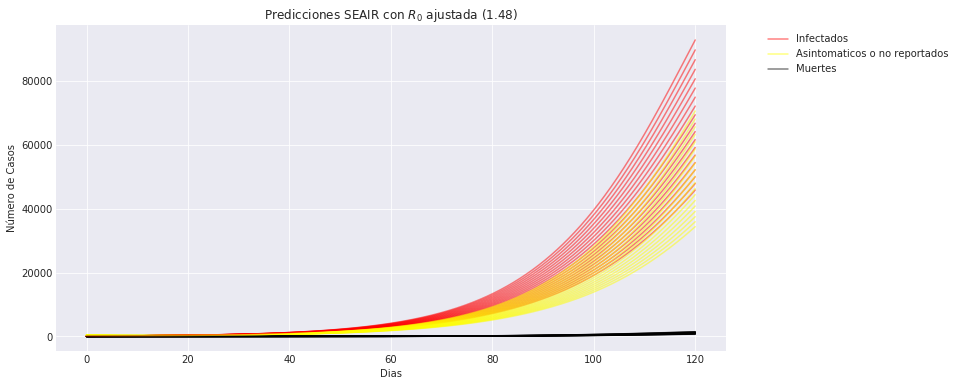

In [113]:
dias_evaluacion = 120
dt=.01
periodo_evaluacion = np.arange(0,dias_evaluacion+dt,dt)
plt.figure(figsize=(12,6))
for beta in Betas[:-1]:
    _,_,A,I,_,D = SEAIR_D(Condiciones_Iniciales, parametros, beta, periodo_evaluacion)
    I = np.array(I)
    A = np.array(A)
    D = np.array(D)
    plt.plot(periodo_evaluacion,I*N,color = "red",alpha = 0.5)
    plt.plot(periodo_evaluacion,A*N,color = "yellow",alpha = 0.5)
    plt.plot(periodo_evaluacion,D*N,color = "black",alpha = 0.5)
_,_,A,I,_,D = SEAIR_D(Condiciones_Iniciales, parametros, Betas[-1], periodo_evaluacion)
I = np.array(I)
A = np.array(A)
D = np.array(D)
plt.plot(periodo_evaluacion,I*N,color = "red",alpha = 0.5, label = "Infectados")
plt.plot(periodo_evaluacion,A*N,color = "yellow",alpha = 0.5, label = "Asintomaticos o no reportados")
plt.plot(periodo_evaluacion,D*N,color = "black",alpha = 0.5, label = "Muertes")
plt.title(f"Predicciones SEAIR con $R_0$ ajustada (1.48)")
plt.xlabel("Dias")
plt.ylabel("Número de Casos")
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')